In [4]:
import pandas as pd
from prophet import Prophet
from CONSTANTS import DATA_PATH

In [7]:
data = pd.read_csv(DATA_PATH + "btc_daily_data_with_features.csv", index_col=0, parse_dates=True)

# Drop NaN values
data = data.dropna()

data.head()

,open,high,low,close,volume,Year,Month,Weekday,Day,rsi,sma_50,sma_200,macd,volatility
2012-04-04,5.04,5.04,4.86,4.99,244.0,2012,4,2,4,51.370026,4.8924,5.01090,-0.027411,0.18
2012-04-05,4.92,5.01,4.86,5.01,305.0,2012,4,3,5,52.007078,4.8948,4.98145,-0.018055,0.15
2012-04-06,4.99,5.04,4.89,5.00,400.0,2012,4,4,6,51.642798,4.9010,4.94800,-0.011318,0.15
2012-04-07,4.90,4.99,4.81,4.99,725.0,2012,4,5,7,51.256161,4.9106,4.91445,-0.006707,0.18
2012-04-08,4.94,4.94,4.70,4.70,228.0,2012,4,6,8,41.542747,4.9112,4.87945,-0.026153,0.24


21:47:00 - cmdstanpy - INFO - Chain [1] start processing
21:47:00 - cmdstanpy - INFO - Chain [1] done processing


MAE: 480.3128248438778
RMSE: 673.2753222234384


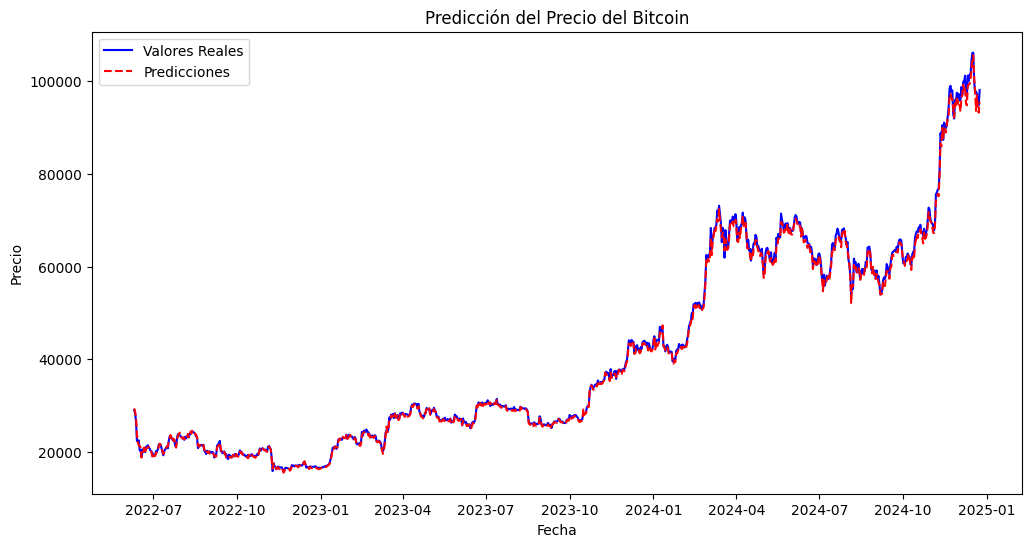

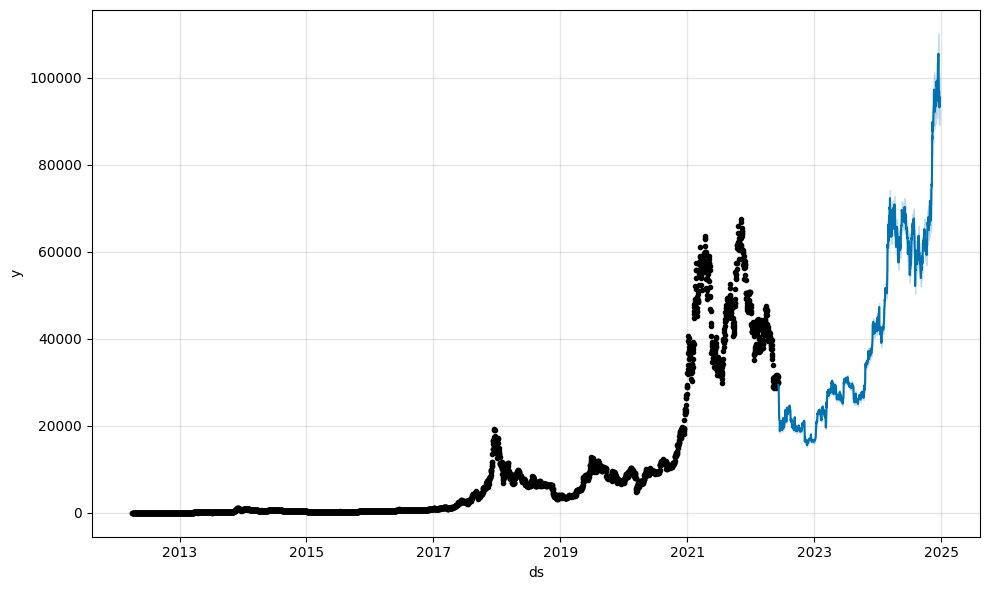

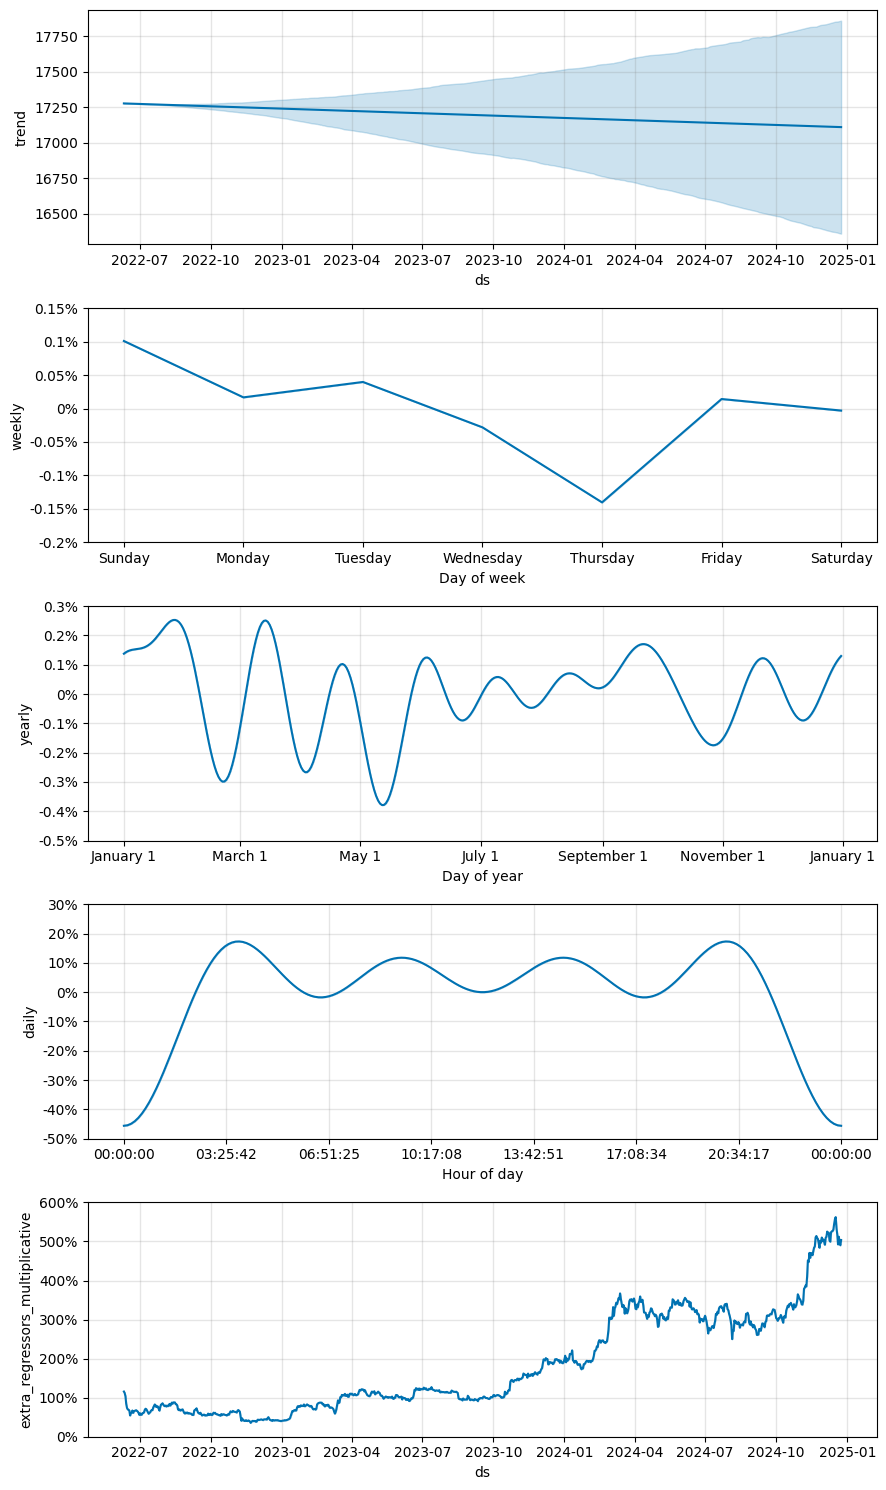

In [10]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

# Paso 1: Preparación de los datos
# Crear una copia para no modificar el original
df_clean = data.copy()

# Eliminar filas con valores NaN (debido a rolling windows)
df_clean = df_clean.dropna()

# Crear la columna necesaria para Prophet: 'ds' (fecha) y 'y' (target)
# Drop columns Year, Month, Day
df_clean = df_clean.drop(columns=["Year", "Month", "Day"])
df_clean["ds"] = df_clean.index
df_clean["y"] = df_clean["close"]

# Paso 2: Dividir los datos en entrenamiento y prueba
# Usamos un 80% para entrenamiento y 20% para prueba
train, test = train_test_split(df_clean, test_size=0.2, shuffle=False)

# Paso 3: Crear el modelo Prophet
model = Prophet(
    seasonality_mode="multiplicative",  # Usamos modo multiplicativo para capturar mejor la estacionalidad
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,  # Puedes activarlo si los datos tienen suficiente granularidad
)

# Agregar características adicionales como regresores
for feature in ["open", "high", "low", "volume", "rsi", "sma_50", "sma_200", "macd", "volatility"]:
    model.add_regressor(feature)

# Paso 4: Entrenamiento del modelo
# Seleccionar las columnas necesarias para Prophet
train_data = train[["ds", "y", "open", "high", "low", "volume", "rsi", "sma_50", "sma_200", "macd", "volatility"]]
model.fit(train_data)

# Paso 5: Realizar predicciones
future = test[["ds", "open", "high", "low", "volume", "rsi", "sma_50", "sma_200", "macd", "volatility"]]
forecast = model.predict(future)

# Paso 6: Evaluación del modelo
# Comparar los valores reales con las predicciones
y_true = test["y"].values
y_pred = forecast["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Paso 7: Visualización de resultados
# Gráfico de las predicciones
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test["ds"], y_true, label="Valores Reales", color="blue")
plt.plot(test["ds"], y_pred, label="Predicciones", color="red", linestyle="--")
plt.title("Predicción del Precio del Bitcoin")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.show()

# Visualización del modelo Prophet
model.plot(forecast)
plt.show()

# Visualización de los componentes del modelo
model.plot_components(forecast)
plt.show()


In [28]:
from fastapi import FastAPI
import pandas as pd

app = FastAPI()

# Cargar el modelo y datos
model = Prophet()
model.fit(data_prophet)

@app.get("/predict")
def predict():
    future = model.make_future_dataframe(periods=30, freq='D')
    forecast = model.predict(future)
    return forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(30).to_dict()

14:25:37 - cmdstanpy - INFO - Chain [1] start processing
14:25:37 - cmdstanpy - INFO - Chain [1] done processing
